In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np

import lightgbm as lgb

#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


import warnings
warnings.filterwarnings('ignore')

# 関数

In [2]:
import gather_function

In [4]:
import importlib
importlib.reload(gather_function)

<module 'gather_function' from '/Users/ryosuke/Desktop/副業/AI Quest/assessment/gather_function.py'>

In [5]:
original_train_data = pd.read_csv('train.csv')
original_test_data = pd.read_csv('test.csv')

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

del train['id']
del test['id']

print('len(train)=', len(train))
print('len(test)', len(test))
print(len(test)/len(train))

len(train)= 55583
len(test) 18528
0.3333393303707968


# 説明変数

|カラム|ヘッダ名称|データ型|説明|
|-|-|-|-|
|0|	id|	int| インデックスとして使用|
|1|	accommodates|	int|	収容可能人数|
|2|	amenities|	char|	アメニティ|
|3|	bathrooms|	float|	風呂数|
|4|	bed_type|	char|	ベッドの種類|
|5|	bedrooms|	float|	ベッドルーム数|
|6|	beds|	float|	ベッド数|
|7|	cancellation_policy|	char|	キャンセルポリシー|
|8|	city|	char|	都市|
|9|	cleaning_fee|	int|	クリーニング料金を含むか|
|10|	description|	char|	説明|
|11|	first_review|	char|	最初のレビュー日|
|12|	host_has_profile_pic|	int|	ホストの写真があるかどうか|
|13|	host_identity_verified|	int|	ホストの身元確認が取れているか|
|14|	host_response_rate|	char|	ホストの返信率|
|15|	host_since|	char|	ホストの登録日|
|16|	instant_bookable|	char|	即時予約可能か|
|17|	last_review	|char|	最後のレビュー日|
|18|	latitude|	float|	緯度|
|19|longitude|	float|	経度|
|20|	name|	char|	物件名|
|21|	neighbourhood|	char|	近隣情報|
|22|	number_of_reviews|	int|	レビュー数|
|23|	property_type|	char|	物件の種類|
|24|	review_scores_rating|	float|	レビュースコア|
|25|	room_type|	char|	部屋の種類|
|26|	thumbnail_url|	char|	サムネイル画像リンク|
|27|	zipcode|	int|	郵便番号|
|28|    y| float|	宿泊価格|

# トレーニングデータの処理

In [7]:
train_y = train['y']
train_X = train.drop('y', axis=1)

In [8]:
train_X_addEDA, max_amenities_list = gather_function.preprocessing(train_X)

100%|███████████████████████████████████████████| 86/86 [00:02<00:00, 29.61it/s]


In [9]:
train_X_addEDA[train_X_addEDA.columns[:99]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 99 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   accommodates                   55583 non-null  int64  
 1   bathrooms                      55583 non-null  int64  
 2   bed_type                       55583 non-null  object 
 3   bedrooms                       55583 non-null  int64  
 4   beds                           55583 non-null  int64  
 5   cancellation_policy            55583 non-null  object 
 6   city                           55583 non-null  object 
 7   cleaning_fee                   55583 non-null  object 
 8   host_has_profile_pic           55583 non-null  object 
 9   host_identity_verified         55583 non-null  object 
 10  host_response_rate             55583 non-null  int64  
 11  instant_bookable               55583 non-null  object 
 12  latitude                       55583 non-null 

## 対数変換した説明変数を追加

['beds_par_1', 'bathrooms_par_1', 'bathrooms', 'review_score_total', 'number_of_reviews', 'beds', 'accommodates', 'bedrooms', 'bedrooms_par_1', 'rare_amenities_count', 'amenities_count', 'latitude', 'host_response_rate_weight', 'review_score_weight', 'description_word_count', 'host_response_rate']


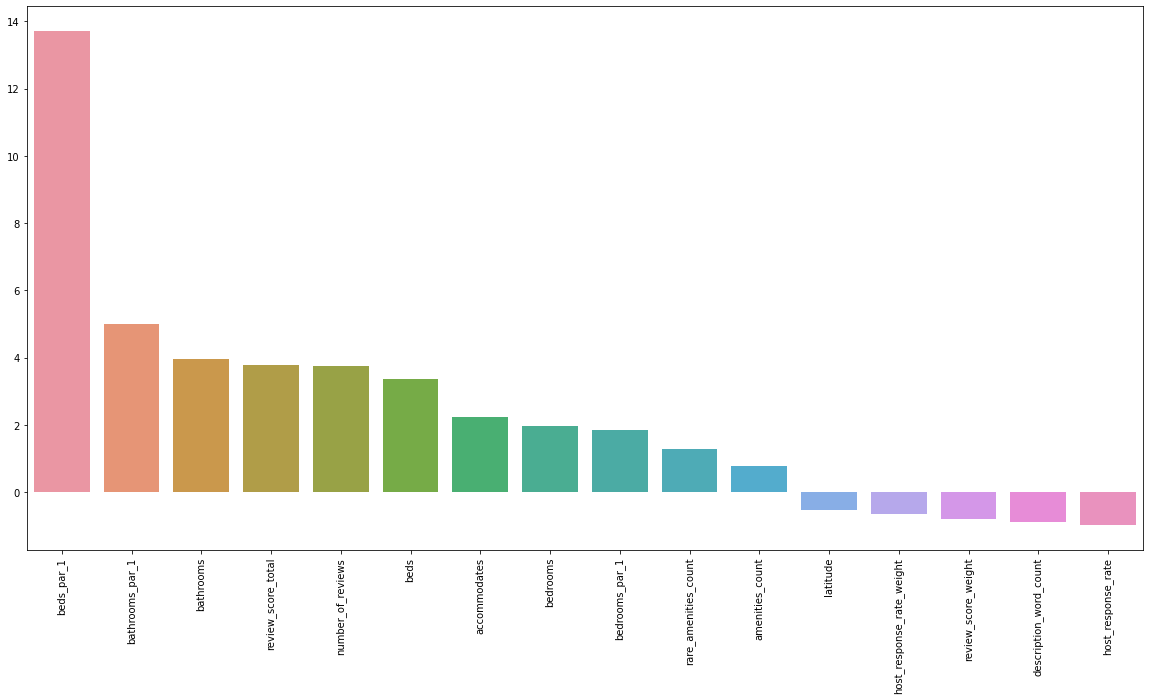

In [10]:
train_X_addEDA_log, num_col_feat_list, pt = gather_function.logarithmic_transformation(train_X_addEDA)

## カテゴリー変数化

In [12]:
#one-hot変換をせずにlabelencodingする → カテゴリ変数化
categorical_columns = ['neighbourhood']

In [13]:
train_X_addEDA_log_dummy = gather_function.process_categorical(train_X_addEDA_log, categorical_columns)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 691.67it/s]


In [14]:
train_X_addEDA_log_dummy[train_X_addEDA_log_dummy.columns[:99]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 99 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   accommodates                         55583 non-null  int64   
 1   bathrooms                            55583 non-null  int64   
 2   bedrooms                             55583 non-null  int64   
 3   beds                                 55583 non-null  int64   
 4   host_response_rate                   55583 non-null  int64   
 5   latitude                             55583 non-null  float64 
 6   longitude                            55583 non-null  float64 
 7   neighbourhood                        55583 non-null  category
 8   number_of_reviews                    55583 non-null  int64   
 9   review_scores_rating                 43027 non-null  float64 
 10  thumbnail_url                        49438 non-null  float64 
 11  bathrooms_par_1

In [15]:
train_X_addEDA_log_dummy.head()

,accommodates,bathrooms,bedrooms,beds,host_response_rate,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,bathrooms_par_1,bedrooms_par_1,beds_par_1,bed_par_bedrooms,latitude_int,longitude_int,review_score_total,review_score_weight,amenities_count,rare_amenities_count,description_word_count,host_response_rate_weight,first_review_Year,first_review_Month,first_review_Day,BusinessOld,host_since_Year,host_since_Month,host_since_Day,BusinessOld2,first_reviewOld,last_review_Year,last_review_Month,last_review_Day,BusinessOld3,BusinessUpdate,BusinessPeriod,zipcode_int,Log_beds_par_1,Log_bathrooms_par_1,Log_bathrooms,Log_review_score_total,Log_number_of_reviews,Log_beds,Log_accommodates,Log_bedrooms,Log_bedrooms_par_1,Log_rare_amenities_count,Log_amenities_count,Log_latitude,Log_host_response_rate_weight,Log_review_score_weight,Log_description_word_count,Log_host_response_rate,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cleaning_fee_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,instant_bookable_t,property_type_Bed & Breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_Earth House,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_House,property_type_Hut,property_type_In-law,property_type_Island,property_type_Loft,property_type_Other,property_type_Parking Space,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tipi,property_type_Townhouse,property_type_Train,property_type_Treehouse,property_type_Vacation home,property_type_Villa,property_type_Yurt,room_type_Private room,room_type_Shared room,TV_True,Cable TV_True,Wireless Internet_True,Air conditioning_True,Kitchen_True,Free parking on premises_True,Pets allowed_True,Breakfast_True,Elevator_True,Hot tub_True,Indoor fireplace_True,Heating_True,Family/kid friendly_True,Suitable for events_True,Washer_True,Dryer_True,Smoke detector_True,Carbon monoxide detector_True,First aid kit_True,Safety card_True,Fire extinguisher_True,Essentials_True,Shampoo_True,Lock on bedroom door_True,Hangers_True,Hair dryer_True,Iron_True,Laptop friendly workspace_True,Self Check-In_True,Keypad_True,Private entrance_True,Baby monitor_True,Bathtub_True,Baby bath_True,Changing table_True,Children’s books and toys_True,Window guards_True,Table corner guards_True,Fireplace guards_True,Babysitter recommendations_True,Crib_True,Room-darkening shades_True,Game console_True,Hot water_True,Bed linens_True,Extra pillows and blankets_True,Ethernet connection_True,Pocket wifi_True,Microwave_True,Coffee maker_True,Refrigerator_True,Dishwasher_True,Dishes and silverware_True,Cooking basics_True,Oven_True,Stove_True,EV charger_True,Single level home_True,BBQ grill_True,Patio or balcony_True,Garden or backyard_True,Beach essentials_True,Luggage dropoff allowed_True,Long term stays allowed_True,Wide hallway clearance_True,Step-free access_True,Wide doorway_True,Flat_True,smooth pathway to front door_True,Well-lit path to entrance_True,Disabled parking spot_True,Wide clearance to bed_True,Accessible-height bed_True,Fixed grab bars for shower & toilet_True,Bathtub with shower chair_True,Roll-in shower with chair_True,Accessible-height toilet_True,Wide clearance to shower & toilet_True,Wide entryway_True,Waterfront_True,Handheld shower head_True,thumbnail_url_str_nan
0,6,2,1,4,0,33.788931,-118.154761,375,1,60.0,NaN,0.333333,0.166667,0.666667,4.0,33,-118,60.0,0.594059,7,6,379,0.000000,2016.0,7.0,27.0,2809.0,2016.0,7.0,13.0,3054.0,14.0,2016.0,7.0,27.0,2809.0,

# 目的変数の処理

歪度: 0.535099
尖度: 0.662021


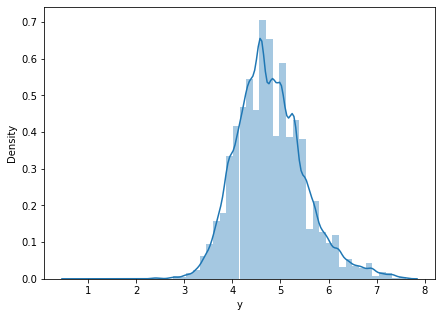

In [17]:
train_y_ac = train_y / train_X_addEDA_log_dummy["accommodates"]
#目的変数の対数log(x+1)をとる
train_y_ac_log = np.log1p(train_y_ac) #②
train_y_log = np.log1p(train_y)#③

#分布を可視化
plt.figure(figsize=(7, 5))
sns.distplot(train_y_log)

#歪度と尖度を計算
print("歪度: %f" % train_y_log.skew())
print("尖度: %f" % train_y_log.kurt())

# データセットを分ける

In [20]:
presplit_train_X = train_X_addEDA_log_dummy
presplit_train_y = train_y

In [21]:
#実際のテストサイズと同じサイズのテストデータを確保してこれでだいたいを測る
train_X, valid_X, train_y, valid_y = train_test_split(presplit_train_X, presplit_train_y, test_size=0.33, random_state=0)

In [25]:
print('len(X_test)', len(train_X))
print('len(train_y)', len(train_y))
print('len(valid_X)', len(valid_X))
print('len(valid_y)', len(valid_y))

len(X_test) 37240
len(train_y) 37240
len(valid_X) 18343
len(valid_y) 18343


歪度: 4.240694
尖度: 25.648410
歪度: 4.310869
尖度: 26.777676


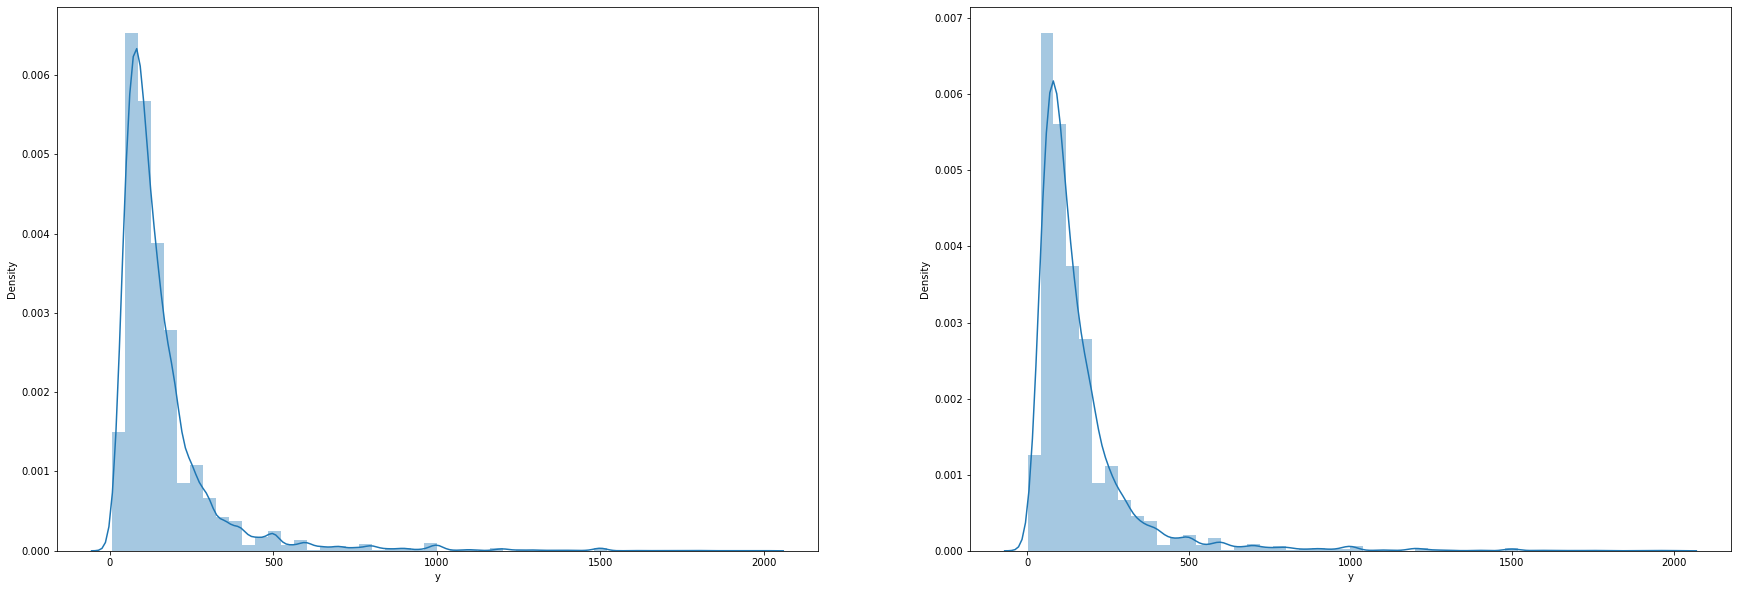

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 10])

sns.distplot(train_y, ax=ax1)
#歪度と尖度を計算
print("歪度: %f" % train_y.skew())
print("尖度: %f" % train_y.kurt())

print('=============')

sns.distplot(valid_y, ax=ax2)
#歪度と尖度を計算
print("歪度: %f" % valid_y.skew())
print("尖度: %f" % valid_y.kurt())

# Submit用のモデル作成

## パラメータチューニング

In [27]:
import optuna.integration.lightgbm as op_lgb
from sklearn import datasets, model_selection

dtrain_tuning = op_lgb.Dataset(train_X.values, label=train_y.values)
dval_tuning = op_lgb.Dataset(valid_X.values, label=valid_y.values)

In [28]:
best_params, tuning_history = dict(), list()
# ハイパーパラメータサーチ&モデル構築(回帰モデル用)
tuning_params = {'objective': 'regression',
          'metric': 'rmse',
#         'boosting_type':'dart',
            'boosting_type':'gbdt',
          'num_boost_round': 5000, # 最大試行数
          'random_seed':100,
         'learning_rate': 0.01, # 学習率
         }

booster = op_lgb.train(tuning_params, 
                       dtrain_tuning, 
                       valid_sets=[dtrain_tuning, dval_tuning],
                       verbose_eval=0,
                       early_stopping_rounds=20,)

[I 2021-08-08 02:59:38,127] A new study created in memory with name: no-name-a4ab41cb-4b64-42b8-95a0-827dd2eae89d
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 104.383385:  14%|5   | 1/7 [00:12<01:15, 12.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 104.383385:  29%|#1  | 2/7 [00:21<00:53, 10.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 104.383385:  43%|#7  | 3/7 [00:31<00:39,  9.96s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 104.383385:  57%|##2 | 4/7 [00:40<00:29,  9.95s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 104.383385:  71%|##8 | 5/7 [00:52<00:20, 10.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 104.383385:  86%|###4| 6/7 [01:04<00:11, 11.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 104.383385:   0%|                 | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 104.068519:   5%|4        | 1/20 [00:35<11:12, 35.38s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 104.068519:  10%|9        | 2/20 [00:56<08:09, 27.22s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.901419:  15%|#3       | 3/20 [01:16<06:41, 23.61s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  20%|#8       | 4/20 [01:38<06:09, 23.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  25%|##2      | 5/20 [02:03<05:58, 23.87s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  30%|##6      | 6/20 [02:25<05:22, 23.03s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  35%|###1     | 7/20 [02:44<04:43, 21.77s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  40%|###6     | 8/20 [02:57<03:48, 19.08s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  45%|####     | 9/20 [03:25<04:00, 21.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  50%|####    | 10/20 [03:46<03:35, 21.56s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.809346:  55%|####4   | 11/20 [04:00<02:53, 19.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  60%|####8   | 12/20 [04:22<02:40, 20.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  65%|#####2  | 13/20 [04:40<02:15, 19.40s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  70%|#####6  | 14/20 [04:56<01:50, 18.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  75%|######  | 15/20 [05:06<01:19, 15.97s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  80%|######4 | 16/20 [05:31<01:13, 18.50s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  85%|######8 | 17/20 [05:59<01:04, 21.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  90%|#######2| 18/20 [06:12<00:37, 19.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 103.401910:  95%|#######6| 19/20 [06:23<00:16, 16.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:   0%|                    | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  10%|#2          | 1/10 [00:12<01:49, 12.13s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  20%|##4         | 2/10 [00:22<01:27, 10.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  30%|###6        | 3/10 [00:34<01:20, 11.47s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  40%|####8       | 4/10 [00:52<01:24, 14.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  50%|######      | 5/10 [01:01<01:01, 12.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  60%|#######2    | 6/10 [01:15<00:51, 12.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  70%|########3   | 7/10 [01:30<00:40, 13.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  80%|#########6  | 8/10 [01:41<00:25, 12.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 103.401910:  90%|##########8 | 9/10 [01:50<00:11, 11.58s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 103.401910:   0%|     | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007943 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 103.401910:  33%|3| 1/3 [00:17<00:35, 17.75s[I 2021-08-08 03:09:47,894] Trial 37 finished with value: 103.80765355574934 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 103.80765355574934.
feature_fraction_stage2, val_score: 103.401910:  33%|3| 1/3 [00:17<00:35, 17.75s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 103.401910:  67%|6| 2/3 [00:37<00:19, 19.14s[I 2021-08-08 03:10:08,003] Trial 38 finished with value: 103.86141443780335 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 103.80765355574934.
feature_fraction_stage2, val_score: 103.401910:  67%|6| 2/3 [00:37<00:19, 19.14s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 103.401910: 100%|#| 3/3 [00:53<00:00, 17.42s[I 2021-08-08 03:10:23,386] Trial 39 finished with value: 104.01598154333287 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 103.80765355574934.
feature_fraction_stage2, val_score: 103.401910: 100%|#| 3/3 [00:53<00:00, 17.75s
regularization_factors, val_score: 103.401910:   0%|     | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:   5%| | 1/20 [00:25<07:57, 25.16s[I 2021-08-08 03:10:48,550] Trial 40 finished with value: 103.49403583103616 and parameters: {'lambda_l1': 5.646153852026822e-05, 'lambda_l2': 2.8995359729426077e-08}. Best is trial 40 with value: 103.49403583103616.
regularization_factors, val_score: 103.401910:   5%| | 1/20 [00:25<07:57, 25.16s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  10%|1| 2/20 [00:46<06:49, 22.75s[I 2021-08-08 03:11:09,611] Trial 41 finished with value: 103.54208063099907 and parameters: {'lambda_l1': 4.7002479155144543e-07, 'lambda_l2': 0.0011226024299761967}. Best is trial 40 with value: 103.49403583103616.
regularization_factors, val_score: 103.401910:  10%|1| 2/20 [00:46<06:49, 22.75s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  15%|1| 3/20 [01:00<05:20, 18.86s[I 2021-08-08 03:11:23,852] Trial 42 finished with value: 103.8351843699507 and parameters: {'lambda_l1': 6.142674745281191e-07, 'lambda_l2': 0.051062876583164496}. Best is trial 40 with value: 103.49403583103616.
regularization_factors, val_score: 103.401910:  15%|1| 3/20 [01:00<05:20, 18.86s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  20%|2| 4/20 [01:19<05:05, 19.10s[I 2021-08-08 03:11:43,326] Trial 43 finished with value: 103.40329179614929 and parameters: {'lambda_l1': 5.416510920600852e-07, 'lambda_l2': 1.7523455374185662e-08}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  20%|2| 4/20 [01:19<05:05, 19.10s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  25%|2| 5/20 [01:35<04:26, 17.75s[I 2021-08-08 03:11:58,686] Trial 44 finished with value: 103.56100262781347 and parameters: {'lambda_l1': 2.0746939740197e-08, 'lambda_l2': 1.3274154616086434e-06}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  25%|2| 5/20 [01:35<04:26, 17.75s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  30%|3| 6/20 [01:50<03:57, 16.95s[I 2021-08-08 03:12:14,081] Trial 45 finished with value: 103.7740883602478 and parameters: {'lambda_l1': 1.5787503314747686, 'lambda_l2': 0.013288662277497405}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  30%|3| 6/20 [01:50<03:57, 16.95s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  35%|3| 7/20 [02:13<04:06, 18.95s[I 2021-08-08 03:12:37,139] Trial 46 finished with value: 103.56869610110851 and parameters: {'lambda_l1': 1.5688375038037254e-07, 'lambda_l2': 4.960095163816138}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  35%|3| 7/20 [02:13<04:06, 18.95s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  40%|4| 8/20 [02:27<03:27, 17.31s[I 2021-08-08 03:12:50,954] Trial 47 finished with value: 103.84239957790625 and parameters: {'lambda_l1': 8.707925481055795e-06, 'lambda_l2': 0.002057640621404746}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  40%|4| 8/20 [02:27<03:27, 17.31s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  45%|4| 9/20 [02:46<03:15, 17.81s[I 2021-08-08 03:13:09,847] Trial 48 finished with value: 103.72916634594722 and parameters: {'lambda_l1': 7.866835603181297, 'lambda_l2': 8.894575747619461e-06}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  45%|4| 9/20 [02:46<03:15, 17.81s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  50%|5| 10/20 [03:03<02:55, 17.55[I 2021-08-08 03:13:26,816] Trial 49 finished with value: 103.8481794147437 and parameters: {'lambda_l1': 2.3544178604084688e-06, 'lambda_l2': 0.044967979286863226}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  50%|5| 10/20 [03:03<02:55, 17.55

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  55%|5| 11/20 [03:22<02:42, 18.07[I 2021-08-08 03:13:46,076] Trial 50 finished with value: 103.56286682315198 and parameters: {'lambda_l1': 0.004207530245147709, 'lambda_l2': 1.5681249564048696e-08}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  55%|5| 11/20 [03:22<02:42, 18.07

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  60%|6| 12/20 [03:43<02:31, 18.98[I 2021-08-08 03:14:07,120] Trial 51 finished with value: 103.46348345722872 and parameters: {'lambda_l1': 0.0004032757111938305, 'lambda_l2': 1.565543366856634e-08}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  60%|6| 12/20 [03:43<02:31, 18.98

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  65%|6| 13/20 [03:57<02:01, 17.34[I 2021-08-08 03:14:20,699] Trial 52 finished with value: 103.84301931978361 and parameters: {'lambda_l1': 0.007811035294746235, 'lambda_l2': 3.4525912385241315e-07}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  65%|6| 13/20 [03:57<02:01, 17.34

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  70%|7| 14/20 [04:16<01:47, 17.89[I 2021-08-08 03:14:39,849] Trial 53 finished with value: 103.66441119886375 and parameters: {'lambda_l1': 0.000947387341212531, 'lambda_l2': 2.402718916630841e-05}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  70%|7| 14/20 [04:16<01:47, 17.89

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  75%|7| 15/20 [04:31<01:24, 16.93[I 2021-08-08 03:14:54,556] Trial 54 finished with value: 103.85820861542743 and parameters: {'lambda_l1': 0.0274721743186443, 'lambda_l2': 1.423961883071715e-08}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  75%|7| 15/20 [04:31<01:24, 16.93

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  80%|8| 16/20 [04:46<01:06, 16.54[I 2021-08-08 03:15:10,186] Trial 55 finished with value: 103.53683797149918 and parameters: {'lambda_l1': 9.313945388877528e-05, 'lambda_l2': 4.664404465316837e-07}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  80%|8| 16/20 [04:46<01:06, 16.54

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  85%|8| 17/20 [05:03<00:49, 16.47[I 2021-08-08 03:15:26,502] Trial 56 finished with value: 103.51891946510905 and parameters: {'lambda_l1': 0.20002595450393174, 'lambda_l2': 6.161082980396783e-08}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  85%|8| 17/20 [05:03<00:49, 16.47

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  90%|9| 18/20 [05:17<00:31, 15.76[I 2021-08-08 03:15:40,603] Trial 57 finished with value: 103.62516575649973 and parameters: {'lambda_l1': 1.797829447151868e-05, 'lambda_l2': 6.941230667002113e-05}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  90%|9| 18/20 [05:17<00:31, 15.76

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910:  95%|9| 19/20 [05:32<00:15, 15.66[I 2021-08-08 03:15:56,024] Trial 58 finished with value: 103.9430448349245 and parameters: {'lambda_l1': 2.1366625707622456e-08, 'lambda_l2': 7.208807074115297}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910:  95%|9| 19/20 [05:32<00:15, 15.66

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 103.401910: 100%|#| 20/20 [05:49<00:00, 15.95[I 2021-08-08 03:16:12,670] Trial 59 finished with value: 103.49169037898552 and parameters: {'lambda_l1': 0.0004325466779566288, 'lambda_l2': 3.344577872043542e-06}. Best is trial 43 with value: 103.40329179614929.
regularization_factors, val_score: 103.401910: 100%|#| 20/20 [05:49<00:00, 17.46
min_data_in_leaf, val_score: 103.401910:   0%|            | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 103.401910:  20%|8   | 1/5 [00:15<01:01, 15.34s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 103.401910:  40%|#6  | 2/5 [00:31<00:48, 16.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 103.401910:  60%|##4 | 3/5 [00:45<00:29, 14.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 103.401910:  80%|###2| 4/5 [01:01<00:15, 15.19s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6620
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 103.401910: 100%|####| 5/5 [01:16<00:00, 15.33s/it]


In [29]:
print('Best Params:', booster.params)
print('Best Iteration:', booster.best_iteration)
print('Best Score:', booster.best_score)

Best Params: {'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt', 'random_seed': 100, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 73, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 20}
Best Iteration: 2684
Best Score: defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 54.618376018938285)]), 'valid_1': OrderedDict([('rmse', 103.40190986657618)])})


# 学習

In [30]:
lgb_train = lgb.Dataset(train_X, train_y) #(DataFrame, Series)
lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train) #(DataFrame, Series)

In [31]:
lgbm_params = {
    "objective":"regression",
    #'boosting_type':'dart',
    'boosting_type':'gbdt',
    "metric":"rmse",
   "verbose":1000,
    "random_seed":0,
    'learning_rate': 0.001,
        }
lgbm_params.update(booster.params)
lgbm_params['num_leaves'] = int(lgbm_params['num_leaves'])
lgbm_params['min_child_samples'] = int(lgbm_params['min_child_samples'])
lgbm_params['bagging_freq'] = int(lgbm_params['bagging_freq'])

print(lgbm_params)

{'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'verbose': 1000, 'random_seed': 100, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 73, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 20}


In [32]:
FIT_PARAMS_LGB = {"num_boost_round": 10000, "early_stopping_rounds": 1000,}

evaluation_results  = {}  # to record evaluation results for plotting
model = lgb.train(lgbm_params, 
                  lgb_train,
                   **FIT_PARAMS_LGB,
                  
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_valid],
                 evals_result = evaluation_results,)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.952477
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.634051
[LightGBM] [Debug] init for col-wise cost 0.007230 seconds, init for row-wise cost 0.015379 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 6809
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 190
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 160.051772
[LightGBM] [Debug] Trained a tree with leaves = 73 and depth = 11
[1]	train's rmse: 166.694	valid's rmse: 168.34
Training unt

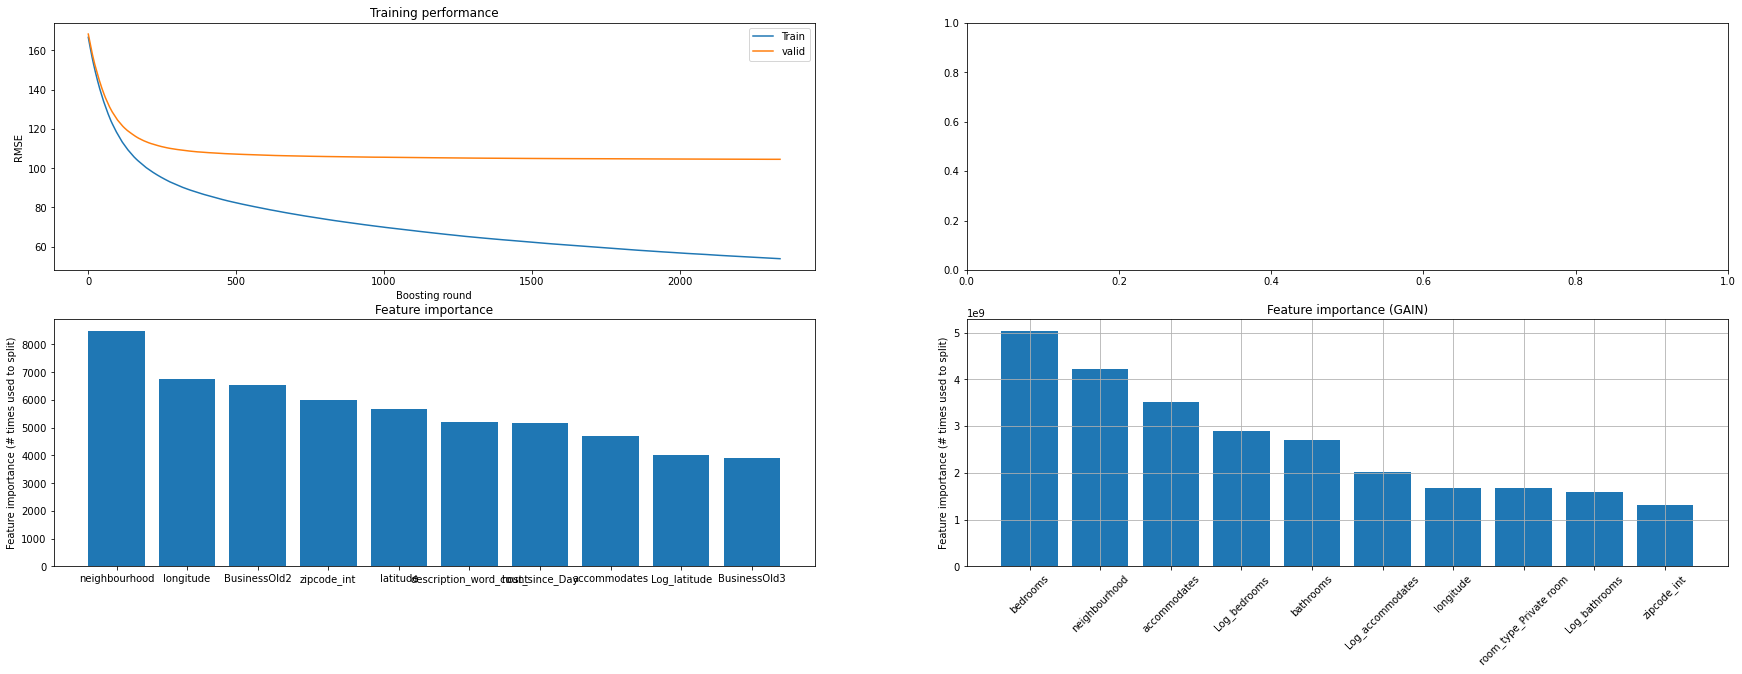

In [62]:
fig, axs = plt.subplots(2, 2, figsize=[30, 10])

# Plot the log loss during training
axs[0,0].plot(evaluation_results['train']['rmse'], label='Train')
axs[0,0].plot(evaluation_results['valid']['rmse'], label='valid')
axs[0,0].set_ylabel('RMSE')
axs[0,0].set_xlabel('Boosting round')
axs[0,0].set_title('Training performance')
axs[0,0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': train_X.columns, 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1,0].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1,0].set_xticks(np.arange(len(importances)))
axs[1,0].set_xticklabels(importances['features'])
axs[1,0].set_ylabel('Feature importance (# times used to split)')
axs[1,0].set_title('Feature importance')
plt.xticks(rotation=45)

# Plot feature importance
pre_importances = pd.DataFrame({'features': train_X.columns, 
                            'importance': model.feature_importance(importance_type='gain')}).sort_values('importance', ascending=False)
importances = pre_importances.head(10)
axs[1,1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1,1].set_xticks(np.arange(len(importances)))
axs[1,1].set_xticklabels(importances['features'])
axs[1,1].set_ylabel('Feature importance (# times used to split)')
axs[1,1].set_title('Feature importance (GAIN)')

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [70]:
pre_importances.tail()

,features,importance
87,property_type_Guest suite,0.0
79,property_type_Camper/RV,0.0
106,property_type_Yurt,0.0
86,property_type_Earth House,0.0
82,property_type_Cave,0.0


In [76]:
pre_importances[pre_importances['features'] == 'bed_par_bedrooms']

,features,importance
14,bed_par_bedrooms,3.882873e+08


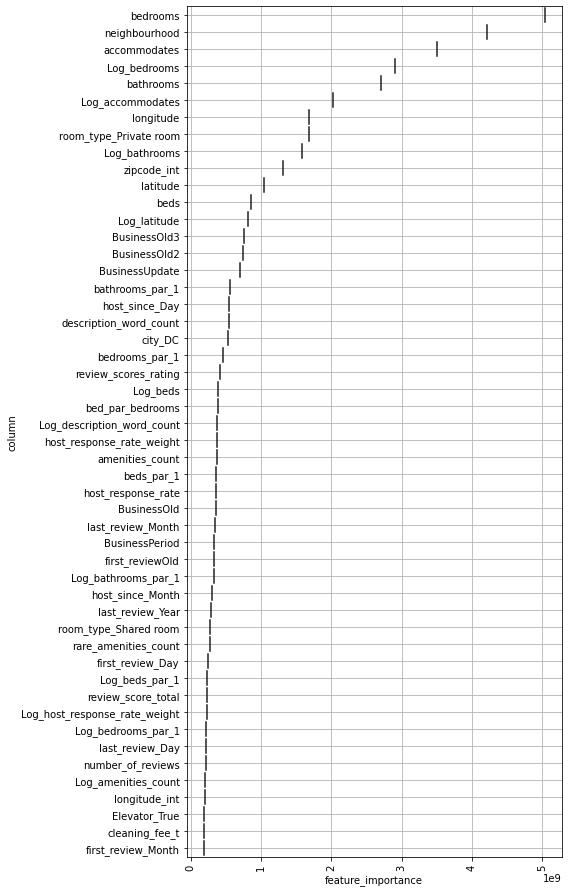

In [52]:
top_n=50
feature_importance_df = pd.DataFrame()

_df = pd.DataFrame()
_df['feature_importance'] = model.feature_importance(importance_type='gain')
_df['column'] = train_X.columns
feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

pre_order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False)
order = pre_order.index[:top_n]

fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
sns.boxenplot(data=feature_importance_df,
              x='feature_importance',
              y='column',
              order=order,
              ax=ax,
              palette='viridis',
              orient='h')
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='x', rotation=90)
ax.grid()
fig.tight_layout()

# テストデータ(submit)

In [35]:
test.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode
0,6,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2.0,Real Bed,2.0,2.0,strict,Boston,t,Feel free to book INSTANTLY. You can check-in ...,2017-01-09,t,f,100%,2016-08-23,t,2017-09-25,42.359278,-71.069962,Gorgeous 2BR/2BA Duplex in Beacon Hill,Beacon Hill,58,House,90.0,Entire home/apt,https://a0.muscache.com/im/pictures/7e4808b4-5...,02114
1,3,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,moderate,LA,t,The guest house is close to: Equinox West Holl...,2016-08-17,t,t,100%,2014-09-03,f,2017-05-02,34.084747,-118.367355,Luxury 1 Bedroom West Hollywood City Center,West Hollywood,4,Guesthouse,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/5392fbd6-6...,90046
2,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,0.0,1.0,flexible,NYC,f,Private room in a three bedroom apartment in N...,NaN,t,t,100%,2012-10-17,f,NaN,40.720541,-73.959192,Bedroom with Patio in Prime Williamsburg Locat...,Williamsburg,0,Apartment,NaN,Private room,https://a0.muscache.com/im/pictures/544d3b89-d...,11249.0
3,4,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,2.0,strict,NYC,f,The apartment is located in historic Bed Stuy ...,NaN,t,t,NaN,2013-01-23,f,NaN,40.681117,-73.944091,Cozy apartment in Brooklyn,Bedford-Stuyvesant,0,Apartment,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/26baf7ba-0...,11216
4,3,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.5,Real Bed,1.0,2.0,strict,LA,t,"Our cozy, pet friendly one bedroom apartment/l...",2015-08-01,t,t,100%,2014-12-28,f,2016-09-11,34.150995,-118.409359,"Cozy, sunny, pet friendly loft/apt",NaN,6,Loft,92.0,Entire home/apt,https://a0.muscache.com/im/pictures/86107545/9...,91604


## 前処理

### 前処理

In [36]:
test_X, _ = gather_function.preprocessing(test, max_amenities_list)

max_amenities_list : 更新


100%|███████████████████████████████████████████| 86/86 [00:01<00:00, 77.71it/s]


In [37]:
test_X.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,bathrooms_par_1,bedrooms_par_1,beds_par_1,bed_par_bedrooms,latitude_int,longitude_int,review_score_total,review_score_weight,amenities_count,TV,Cable TV,Wireless Internet,Air conditioning,Kitchen,Free parking on premises,Pets allowed,Breakfast,Elevator,Hot tub,Indoor fireplace,Heating,Family/kid friendly,Suitable for events,Washer,Dryer,Smoke detector,Carbon monoxide detector,First aid kit,Safety card,Fire extinguisher,Essentials,Shampoo,Lock on bedroom door,Hangers,Hair dryer,Iron,Laptop friendly workspace,Self Check-In,Keypad,Private entrance,Baby monitor,Bathtub,Baby bath,Changing table,Children’s books and toys,Window guards,Table corner guards,Fireplace guards,Babysitter recommendations,Crib,Room-darkening shades,Game console,Hot water,Bed linens,Extra pillows and blankets,Ethernet connection,Pocket wifi,Microwave,Coffee maker,Refrigerator,Dishwasher,Dishes and silverware,Cooking basics,Oven,Stove,EV charger,Single level home,BBQ grill,Patio or balcony,Garden or backyard,Beach essentials,Luggage dropoff allowed,Long term stays allowed,Wide hallway clearance,Step-free access,Wide doorway,Flat,smooth pathway to front door,Well-lit path to entrance,Disabled parking spot,Wide clearance to bed,Accessible-height bed,Fixed grab bars for shower & toilet,Bathtub with shower chair,Roll-in shower with chair,Accessible-height toilet,Wide clearance to shower & toilet,Wide entryway,Waterfront,Handheld shower head,rare_amenities_count,description_word_count,host_response_rate_weight,first_review_Year,first_review_Month,first_review_Day,BusinessOld,host_since_Year,host_since_Month,host_since_Day,BusinessOld2,first_reviewOld,last_review_Year,last_review_Month,last_review_Day,BusinessOld3,BusinessUpdate,BusinessPeriod,thumbnail_url_str,zipcode_int
0,6,2,Real Bed,2,2,strict,Boston,t,t,f,100,t,42.359278,-71.069962,Beacon Hill,58,House,90.0,Entire home/apt,1.0,0.333333,0.333333,0.333333,1.0,42,-71,5220.0,0.569620,21,True,True,True,True,True,False,False,False,False,False,True,True,True,False,True,True,True,True,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,24,1000,63.291139,2017.0,1.0,9.0,2975.0,2016.0,8.0,23.0,3095.0,139.0,2017.0,9.0,25.0,3234.0,1557.0,259.0,1,2114
1,3,1,Real Bed,1,1,moderate,LA,t,t,t,100,f,34.084747,-118.367355,West Hollywood,4,Guesthouse,100.0,Entire home/apt,1.0,0.333333,0.333333,0.333333,1.0,34,-118,400.0,0.961538,20,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,True,True,False,False,True,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,24,1000,96.153846,2016.0,8.0,17.0,2830.0,2014.0,9.0,3.0,2375.0,714.0,2017.0,5.0,2.0,3088.0,1703.0,258.0,1,90046
2,2,1,Real Bed,0,1,flexible,NYC,f,t,t,100,f,40.720541,-73.959192,Williamsburg,0,Apartment,NaN,Private room,1.0,0.500000,0.000000,0.500000,0.0,40,-73,0.0,0.000000,10,True,False,True,True,True,False,False,False,False,False,False,True,True,False,True,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

### 対数化

In [39]:
test_X_log = test_X.copy()
tmp = pd.DataFrame()
tmp[num_col_feat_list] = pt.transform(test_X[num_col_feat_list])
tmp = tmp.add_prefix('Log_')
test_X_log[tmp.columns] = tmp
test_X_log.head()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,bathrooms_par_1,bedrooms_par_1,beds_par_1,bed_par_bedrooms,latitude_int,longitude_int,review_score_total,review_score_weight,amenities_count,TV,Cable TV,Wireless Internet,Air conditioning,Kitchen,Free parking on premises,Pets allowed,Breakfast,Elevator,Hot tub,Indoor fireplace,Heating,Family/kid friendly,Suitable for events,Washer,Dryer,Smoke detector,Carbon monoxide detector,First aid kit,Safety card,Fire extinguisher,Essentials,Shampoo,Lock on bedroom door,Hangers,Hair dryer,Iron,Laptop friendly workspace,Self Check-In,Keypad,Private entrance,Baby monitor,Bathtub,Baby bath,Changing table,Children’s books and toys,Window guards,Table corner guards,Fireplace guards,Babysitter recommendations,Crib,Room-darkening shades,Game console,Hot water,Bed linens,Extra pillows and blankets,Ethernet connection,Pocket wifi,Microwave,Coffee maker,Refrigerator,Dishwasher,Dishes and silverware,Cooking basics,Oven,Stove,EV charger,Single level home,BBQ grill,Patio or balcony,Garden or backyard,Beach essentials,Luggage dropoff allowed,Long term stays allowed,Wide hallway clearance,Step-free access,Wide doorway,Flat,smooth pathway to front door,Well-lit path to entrance,Disabled parking spot,Wide clearance to bed,Accessible-height bed,Fixed grab bars for shower & toilet,Bathtub with shower chair,Roll-in shower with chair,Accessible-height toilet,Wide clearance to shower & toilet,Wide entryway,Waterfront,Handheld shower head,rare_amenities_count,description_word_count,host_response_rate_weight,first_review_Year,first_review_Month,first_review_Day,BusinessOld,host_since_Year,host_since_Month,host_since_Day,BusinessOld2,first_reviewOld,last_review_Year,last_review_Month,last_review_Day,BusinessOld3,BusinessUpdate,BusinessPeriod,thumbnail_url_str,zipcode_int,Log_beds_par_1,Log_bathrooms_par_1,Log_bathrooms,Log_review_score_total,Log_number_of_reviews,Log_beds,Log_accommodates,Log_bedrooms,Log_bedrooms_par_1,Log_rare_amenities_count,Log_amenities_count,Log_latitude,Log_host_response_rate_weight,Log_review_score_weight,Log_description_word_count,Log_host_response_rate
0,6,2,Real Bed,2,2,strict,Boston,t,t,f,100,t,42.359278,-71.069962,Beacon Hill,58,House,90.0,Entire home/apt,1.0,0.333333,0.333333,0.333333,1.0,42,-71,5220.0,0.569620,21,True,True,True,True,True,False,False,False,False,False,True,True,True,False,True,True,True,True,False,False,False,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,24,1000,63.291139,2017.0,1.0,9.0,2975.0,2016.0,8.0,23.0,3095.0,139.0,2017.0,9.0,25.0,3234.0,1557.0,259.0,1,2114,-1.376763,-0.482101,1.687346,1.200628,1.325752,0.813030,1.393625,0.995675,-0.426083,0.639636,0.538261,1.592091,0.251120,-0.382477,0.782058,0.655069
1,3,1,Real Bed,1,1,moderate,LA,t,t,t,100,f,34.084747,-118.367355,West Hollywood,4,Guesthouse,100.0,Entire home/apt,1.0,0.333333,0.333333,0.333333,1.0,34,-118,400.0,0.961538,20,True,True,True,True,True,True,False,False,False,False,False,True,False,False,False,False,True,True,False,False,True,True,True,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,24,1000,96.153846,2016.0,8.0,17.0,2830.0,2014.0,9.0,3.0,2375.0,714.0,2017.0,5.0,2.0,3088.0,1703.0,258.0,1

### ダミー変数化

In [40]:
def fit_LabelEncoding(categorical_columns, training_df, test_df):
    
    for column in tqdm(categorical_columns):
        df = test_df.copy()
        le_column = LabelEncoder().fit(training_df[column].fillna('Na'))
        mask = df[column].isin(le_column.classes_)
        column_new_data = df[column].mask(mask).unique()
        le_column.classes_ = np.concatenate([le_column.classes_, column_new_data])
        df[column] = le_column.transform(df[column])
        
    df[categorical_columns] = df[categorical_columns].astype('category')

    return df

def fit_dummy(categorical_columns, training_df, test_df):
    df = test_df.copy()
    fit_dummy_columns = []
    for i in training_df.select_dtypes(include=object).columns.tolist():
        if i not in categorical_columns:
            fit_dummy_columns.append(i)
            
    for column in tqdm(training_df[fit_dummy_columns].columns):
        fit_type = training_df[column].dropna().unique()
        #NA = training_df[column].value_counts(dropna=False).index[0]
        df[column] = pd.Categorical(df[column], fit_type)
        
    df = pd.get_dummies(df, columns=fit_dummy_columns, drop_first=True)
    return df

In [41]:
test_X_log_dummy = fit_LabelEncoding(categorical_columns, train_X_addEDA, test_X_log)
test_X_log_dummy = fit_dummy(categorical_columns, train_X_addEDA, test_X_log_dummy)


100%|██████████████████████████████████████████| 91/91 [00:00<00:00, 133.08it/s]


In [42]:
test_X_log_dummy.head()

,accommodates,bathrooms,bedrooms,beds,host_response_rate,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,bathrooms_par_1,bedrooms_par_1,beds_par_1,bed_par_bedrooms,latitude_int,longitude_int,review_score_total,review_score_weight,amenities_count,rare_amenities_count,description_word_count,host_response_rate_weight,first_review_Year,first_review_Month,first_review_Day,BusinessOld,host_since_Year,host_since_Month,host_since_Day,BusinessOld2,first_reviewOld,last_review_Year,last_review_Month,last_review_Day,BusinessOld3,BusinessUpdate,BusinessPeriod,zipcode_int,Log_beds_par_1,Log_bathrooms_par_1,Log_bathrooms,Log_review_score_total,Log_number_of_reviews,Log_beds,Log_accommodates,Log_bedrooms,Log_bedrooms_par_1,Log_rare_amenities_count,Log_amenities_count,Log_latitude,Log_host_response_rate_weight,Log_review_score_weight,Log_description_word_count,Log_host_response_rate,bed_type_Pull-out Sofa,bed_type_Airbed,bed_type_Futon,bed_type_Couch,cancellation_policy_strict,cancellation_policy_moderate,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,city_DC,city_NYC,city_SF,city_Chicago,city_Boston,cleaning_fee_f,host_has_profile_pic_Na,host_has_profile_pic_f,host_identity_verified_t,host_identity_verified_Na,instant_bookable_t,property_type_House,property_type_Townhouse,property_type_Loft,property_type_Cabin,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Other,property_type_Bungalow,property_type_Villa,property_type_Bed & Breakfast,property_type_Dorm,property_type_Timeshare,property_type_Camper/RV,property_type_Cave,property_type_Hostel,property_type_Earth House,property_type_In-law,property_type_Serviced apartment,property_type_Boat,property_type_Tent,property_type_Castle,property_type_Boutique hotel,property_type_Vacation home,property_type_Hut,property_type_Treehouse,property_type_Yurt,property_type_Chalet,property_type_Island,property_type_Tipi,property_type_Train,property_type_Parking Space,property_type_Casa particular,room_type_Entire home/apt,room_type_Shared room,TV_False,Cable TV_True,Wireless Internet_False,Air conditioning_True,Kitchen_False,Free parking on premises_False,Pets allowed_True,Breakfast_True,Elevator_True,Hot tub_True,Indoor fireplace_True,Heating_True,Family/kid friendly_True,Suitable for events_True,Washer_False,Dryer_False,Smoke detector_False,Carbon monoxide detector_True,First aid kit_True,Safety card_True,Fire extinguisher_True,Essentials_True,Shampoo_True,Lock on bedroom door_True,Hangers_True,Hair dryer_True,Iron_True,Laptop friendly workspace_True,Self Check-In_True,Keypad_True,Private entrance_True,Baby monitor_True,Bathtub_True,Baby bath_True,Changing table_True,Children’s books and toys_True,Window guards_True,Table corner guards_True,Fireplace guards_True,Babysitter recommendations_True,Crib_True,Room-darkening shades_True,Game console_True,Hot water_True,Bed linens_True,Extra pillows and blankets_True,Ethernet connection_True,Pocket wifi_True,Microwave_True,Coffee maker_True,Refrigerator_True,Dishwasher_True,Dishes and silverware_True,Cooking basics_True,Oven_True,Stove_True,EV charger_True,Single level home_True,BBQ grill_True,Patio or balcony_True,Garden or backyard_True,Beach essentials_True,Luggage dropoff allowed_True,Long term stays allowed_True,Wide hallway clearance_True,Step-free access_True,Wide doorway_True,Flat_True,smooth pathway to front door_True,Well-lit path to entrance_True,Disabled parking spot_True,Wide clearance to bed_True,Accessible-height bed_True,Fixed grab bars for shower & toilet_True,Bathtub with shower chair_True,Roll-in shower with chair_True,Accessible-height toilet_True,Wide clearance to shower & toilet_True,Wide entryway_True,Waterfront_True,Handheld shower head_True,thumbnail_url_str_1
0,6,2,2,2,100,42.359278,-71.069962,40,58,90.0,1.0,0.333333,0.333333,0.333333,1.0,42,-71,5220.0,0.569620,21,24,1000,63.291139,2017.0,1.0,9.0,2975.0,2016.0,8.0,23.0,3095.0,139.0,2017.

# Submit

In [43]:
sub_preds = pd.Series(model.predict(test_X_log_dummy.values,num_iteration=model.best_iteration))

In [44]:
#submit用のCSVを作成
sub = pd.DataFrame({"id":original_test_data['id'], "y":sub_preds})
print('sub["y"].isnull().sum()=', sub['y'].isnull().sum())
sub

sub["y"].isnull().sum()= 0


,id,y
0,0,185.311747
1,1,106.126052
2,2,148.551651
3,3,168.563524
4,4,83.383462
...,...,...
18523,18523,212.222123
18524,18524,76.352099
18525,18525,118.671890
18526,18526,85.680771


In [45]:
sub.to_csv('fifth_submission.csv', header=False, index=False)